<font size="8"> **Creating a two-dimensional bathymetry dataset** </font>  
We will use temperature data (`temp`), a three-dimensional output in ACCESS-OM2-01, to create a two-dimensional bathymetry file from where we can extract depth at each grid cell.  
  
From the 2-D bathymetry file we will calculate the bottom slope in degrees.

# Loading modules

In [96]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

In [97]:
#Accessing model data
import cosima_cookbook as cc
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
#Spatial analysis
from xrspatial import slope

# Accessing ACCESS-OM2-01 outputs

In [98]:
#Starting cookbook session to search for temperature data
session = cc.database.create_session()
#Load temperature data for a single month
temp = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'temp', session, n = 1)
#Extract data for the Southern Ocean only
temp = temp.isel(time = 0).sel(yt_ocean = slice(-90, -45))
#Fixing longitude values
temp = uf.corrlong(temp)
#Check results
temp

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(75, 740, 3600), dtype=float32, chunksize=(19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      datetime64[ns] 1958-01-16T12:00:00
Attributes: (12/13)
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

# Creating 2-D bathymetry file
To achieve this we will do the following:
1. Create a data array with the same shape than our `temp` variable above. Grid cells with temperature values in the original data array will be replaced by a value of `1`.
2. Calculate cumulative sums for each grid cell along the depth dimension (`st_ocean`) and ensure original `NaN` values are kept after calculations. This step will help us identify the maximum depth.
3. Identify the maximum value in each grid cell along the depth dimension (`st_ocean`) and return the depth value (i.e., `st_ocean` label at the maximum depth).

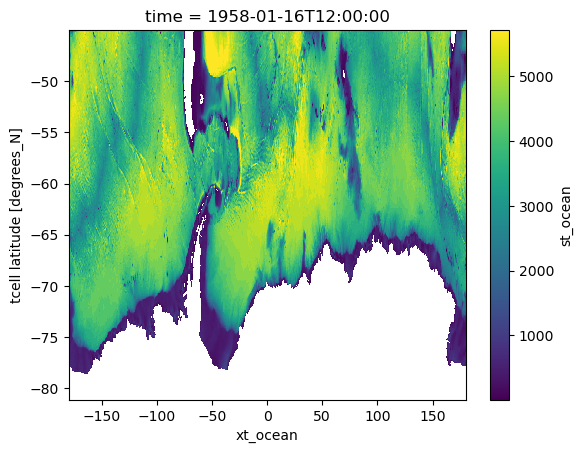

In [100]:
#Create a new data array of the same dimensions as temp data filled with ones
depth_2D = xr.where(~np.isnan(temp), 1, np.nan)
#Calculate cumulative sum along depth dimension
depth_2D = depth_2D.cumsum('st_ocean').where(~np.isnan(temp))
#Identify max value along depth and return st_ocean label
depth_2D = depth_2D.idxmax('st_ocean')
#Check results
depth_2D.plot()

In [101]:
depth_2D = depth_2D.drop('time')
depth_2D

<xarray.DataArray 'st_ocean' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<where, shape=(740, 3600), dtype=float64, chunksize=(9, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04

## Checking results
Comparing unique depth values from 2-D masks to unique depth values from original grid.

In [102]:
np.unique(depth_2D.values)

array([   9.44688511,   11.52234459,   13.81592751,   16.35055351,
         19.15154076,   22.24687195,   25.66745949,   29.44745636,
         33.62459946,   38.24056625,   43.34140396,   48.97796249,
         55.20640182,   62.08873749,   69.69342041,   78.0960083 ,
         87.37988281,   97.63699341,  108.96874237,  121.48686218,
        135.31442261,  150.58683777,  167.45300293,  186.07646179,
        206.63653564,  229.32957458,  254.37013245,  281.99197388,
        312.44915771,  346.01663208,  382.99057007,  423.68832397,
        468.44750977,  517.62414551,  571.58990479,  630.72753906,
        695.42480469,  766.06677246,  843.0255127 ,  926.64819336,
       1017.24371338, 1115.06799316, 1220.30944824, 1333.0760498 ,
       1453.38439941, 1581.15368652, 1716.20471191, 1858.26403809,
       2006.97521973, 2161.9128418 , 2322.60131836, 2488.53320312,
       2659.18920898, 2834.05395508, 3012.63134766, 3194.45336914,
       3379.08862305, 3566.14526367, 3755.27416992, 3946.16601

In [103]:
temp.st_ocean.values

array([5.41280746e-01, 1.68073463e+00, 2.93995261e+00, 4.33152151e+00,
       5.86935043e+00, 7.56880999e+00, 9.44688511e+00, 1.15223446e+01,
       1.38159275e+01, 1.63505535e+01, 1.91515408e+01, 2.22468719e+01,
       2.56674595e+01, 2.94474564e+01, 3.36245995e+01, 3.82405663e+01,
       4.33414040e+01, 4.89779625e+01, 5.52064018e+01, 6.20887375e+01,
       6.96934204e+01, 7.80960083e+01, 8.73798828e+01, 9.76369934e+01,
       1.08968742e+02, 1.21486862e+02, 1.35314423e+02, 1.50586838e+02,
       1.67453003e+02, 1.86076462e+02, 2.06636536e+02, 2.29329575e+02,
       2.54370132e+02, 2.81991974e+02, 3.12449158e+02, 3.46016632e+02,
       3.82990570e+02, 4.23688324e+02, 4.68447510e+02, 5.17624146e+02,
       5.71589905e+02, 6.30727539e+02, 6.95424805e+02, 7.66066772e+02,
       8.43025513e+02, 9.26648193e+02, 1.01724371e+03, 1.11506799e+03,
       1.22030945e+03, 1.33307605e+03, 1.45338440e+03, 1.58115369e+03,
       1.71620471e+03, 1.85826404e+03, 2.00697522e+03, 2.16191284e+03,
      

## Adding some metadata
Recording units and variable name in the data array.

In [108]:
depth_2D = depth_2D.assign_attrs({'name': 'depth', 'units': 'metres'})
depth_2D

<xarray.DataArray 'st_ocean' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<where, shape=(740, 3600), dtype=float64, chunksize=(9, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    name:     depth
    units:    metres

# Saving results

In [109]:
#Path to folder where data will be stored
base_folder = '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'
#Ensuring folder exists
os.makedirs(base_folder, exist_ok = True)

#Saving results
depth_2D.to_netcdf(os.path.join(base_folder, 'bathymetry_2D.nc'))

# Calculating bottom slope
We will use the `xarray_spatial` library to calculate the bottom slope (in degrees) from the 2D bathymetry data. 

In [110]:
bathy_slope = slope(depth_2D)

## Adding some metadata
Recording units and variable name in the data array.

In [111]:
bathy_slope = bathy_slope.assign_attrs({'name': 'slope',
                                        'units': 'degrees'})
bathy_slope

<xarray.DataArray 'slope' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<_trim, shape=(740, 3600), dtype=float64, chunksize=(9, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    name:     slope
    units:    degrees

## Plotting results

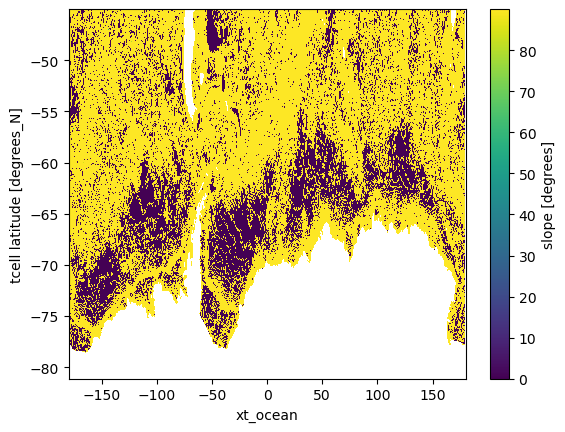

In [112]:
bathy_slope.plot()

## Saving results

In [113]:
bathy_slope.to_netcdf(os.path.join(base_folder, 'bathy_slope_2D.nc'))